In [1]:
import os
os.system("nvidia-smi")

0

In [6]:
import os
import os.path as osp
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")
import numpy as np
import re
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import string

import pickle
import random
import collections

In [220]:
cv_path = "C:\\Users\\meais\\Documents\\CMU\\Independent Study\\Chemu Data\\task2a-reaction-ref-train-dev\\dev-vis\\spans\\"
train_path = "C:\\Users\\meais\\Documents\\CMU\\Independent Study\\Chemu Data\\task2a-reaction-ref-train-dev\\train-vis\\spans\\"

In [38]:
text = """sample text"""
len(text)

11

In [36]:
text[75738:76112] == "Example 35 The preparation of N-(3,4-difluorophenyl)-2-fluoro-5-((2-methylthiazol-4-yl) ethynyl) benzamide (ZD066)\n2-ethynylpyridine was replaced by 4-ethynyl-2-methylthiazole, 4-fluoroaniline was replaced by 3,4-difluoroaniline, while the remaining raw materials, reagents and the preparation method were the same as those in Example 1 to give the product ZD066, yield 80%."

True

In [ ]:
# train vs dev/cv distributions
# Calculate distribution of number of paragraphs in the patents
# Calculate distribtion of number of words in the patents

In [162]:
def getFiles(path):
    all_files = os.listdir(path)
    text_files = [f for f in all_files if f[-3:]=='txt']
    ann_files = [f for f in all_files if f[-3:]=='ann']
    print("Numer of ann files: ", len(ann_files))
    print("Numer of text files: ", len(text_files))
    return text_files, ann_files
    
def getTextFileStats(path, text_files):
    # para == line
    words_per_para = [] #para length
    paras_per_document = []
    words_per_document = []
    
    punctuation = '!"#$%&\'()*,./:;<>?@[\\]^_`{|}~'

    for f in text_files:
        wpp = []
        ppd = 0

        with open(osp.join(path, f), encoding="utf-8" ) as fp:
            lines = fp.readlines()
            for line in lines:
                ppd += 1 
                
                line = line.lower().translate(str.maketrans('', '', punctuation))
                wpp.append(sum([1 for word in nltk.word_tokenize(line) if word not in english_stopwords]))
        
        words_per_para.extend(wpp)
        paras_per_document.append(ppd)
        words_per_document.append(sum(wpp))
 
            
    return words_per_para, paras_per_document, words_per_document

def analyze(path, text_files, words_per_para, paras_per_document, words_per_document):
    print("Analyzing corpus at: ",  path)
    print("Numer of text files: ", len(text_files))
    print("Total words in the corpus: ", np.sum(words_per_document))
    print("Total paras in the corpus: ", np.sum(paras_per_document))
    print("Average number of tokens per para: ", np.mean(words_per_para))
    print("Average number of paras per document: ", np.mean(paras_per_document))

def visualize(values, max_val = 512, bins = 100):#512 is bert token limit
    print(max(values))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    _,_,_ = ax1.hist([min(w, 512) for w in values],bins = bins)
    _,_,_ = ax2.hist([w for w in values],bins = bins)  

In [163]:
text_files, ann_files = getFiles(cv_path)

Numer of ann files:  30
Numer of text files:  30


In [164]:
words_per_para, paras_per_document, words_per_document = getTextFileStats(cv_path, text_files)

In [165]:
analyze(cv_path, text_files, words_per_para, paras_per_document, words_per_document)

Analyzing corpus at:  C:\Users\meais\Documents\CMU\Independent Study\Chemu Data\task2a-reaction-ref-train-dev\dev-vis\spans\
Numer of text files:  30
Total words in the corpus:  294931
Total paras in the corpus:  12871
Average number of tokens per para:  22.914381166964493
Average number of paras per document:  429.03333333333336


In [166]:
train_text_files, train_ann_files = getFiles(train_path)
train_words_per_para, train_paras_per_document, train_words_per_document = getTextFileStats(train_path, train_text_files)

Numer of ann files:  120
Numer of text files:  120


In [167]:
analyze(train_path, train_text_files, train_words_per_para, train_paras_per_document, train_words_per_document)

Analyzing corpus at:  C:\Users\meais\Documents\CMU\Independent Study\Chemu Data\task2a-reaction-ref-train-dev\train-vis\spans\
Numer of text files:  120
Total words in the corpus:  1186263
Total paras in the corpus:  53563
Average number of tokens per para:  22.147060470847414
Average number of paras per document:  446.35833333333335


1808


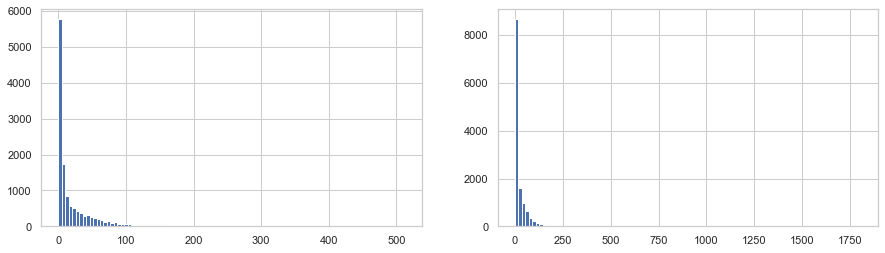

In [168]:
visualize(words_per_para)

3793


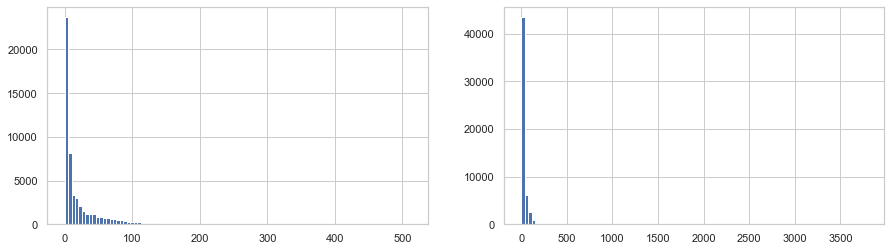

In [169]:
visualize(train_words_per_para)

955


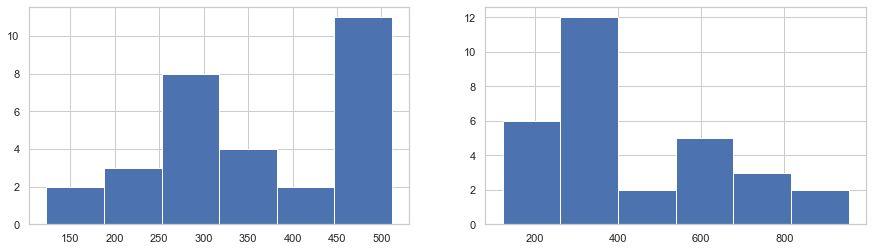

In [170]:
visualize(paras_per_document, bins = 'auto')

2677


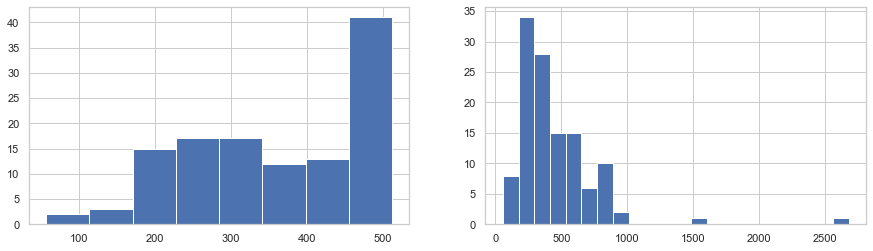

In [171]:
visualize(train_paras_per_document, bins = 'auto')

18619


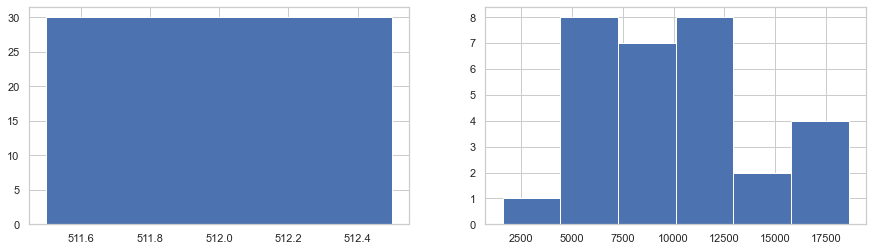

In [172]:
visualize(words_per_document, bins = 'auto')

24813


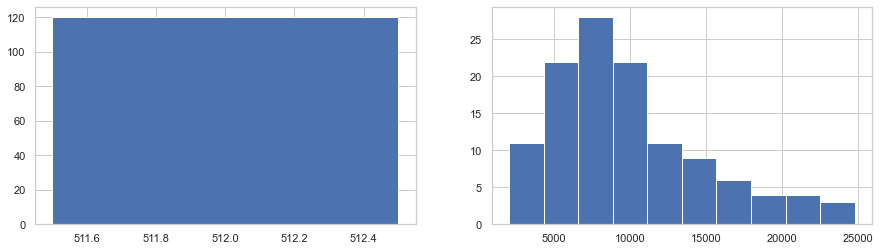

In [173]:
visualize(train_words_per_document, bins = 'auto')

In [228]:
   
def labelReactions(path, ann_files, text_files):
    reactions_per_document = []
    labels = {}
    ann_files.sort()
    text_files.sort()
    
    for af, tf in zip(ann_files, text_files):
        with open(osp.join(path, tf), 'r',encoding="utf-8" ) as fp:
            with open(osp.join(path, af), 'r', encoding="utf-8" ) as ap:
                data = fp.read().rstrip()
                
                paras = data.count('\n')+1
              
                para_labels = np.zeros(paras)

                rpd = 0

                lines = ap.readlines()
                for line in lines:

                    ts = line.split()
                    if(ts[1] == "REACTION_SPAN"):
                        rpd +=1
                        st = data[:int(ts[2])].count('\n')
                        cnts = data[int(ts[2]):int(ts[3])].count('\n')+1
                        for i in range(st, st+cnts):
                            para_labels[i]=1;
                
#                 filter_mask = [True for i in paras]
                
#                 for m in re.finditer("<img>(?s)(.*?)</img>(\n)?", data):
#                     s, e = m.span()
#                     st = data[:s].count('\n')
#                     cnts = data[s:e].count('\n')
#                     for i in range(st, st+cnts):
#                         filter_mask[i]=False;
#                     if(data[e]!='\n'):
#                         filter_mask[st+cnts]=False;
                        
#                 for m in re.finditer("<table>(?s)(.*?)</table>(\n)?", data):
#                     s, e = m.span()
#                     st = data[:s].count('\n')
#                     cnts = data[s:e].count('\n')
#                     for i in range(st, st+cnts):
#                         filter_mask[i]=False;
#                     if(data[e]!='\n'):
#                         filter_mask[st+cnts]=False;     
                            
#                 para_labels = para_labels[filter_mask]

                
#                 data = re.sub("<img>(?s)(.*)</img>", "", s)
#                 data = re.sub("<table>(?s)(.*?)</table>", "", s)

                labels[tf[:-4]] = para_labels
                reactions_per_document.append(rpd)
    
    return labels, reactions_per_document

In [232]:
labels, reactions_per_document = labelReactions(cv_path, ann_files, text_files)
with open('dev_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [236]:
print("Total dev reactions: ", sum(reactions_per_document))

Total dev reactions:  1244


129


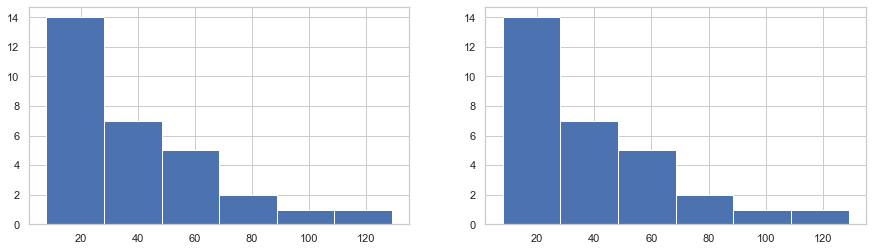

In [233]:
visualize(reactions_per_document, bins = 'auto')

In [234]:
train_labels, train_reactions_per_document = labelReactions(train_path, train_ann_files, train_text_files)
with open('train_labels.pkl', 'wb') as f:
    pickle.dump(train_labels, f)

820


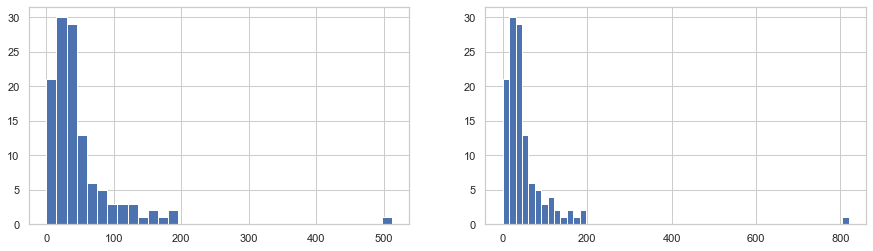

In [235]:
visualize(train_reactions_per_document, bins = 'auto')

In [52]:
# Analysis: Character level — start and end paras might not contain the reaction span from the 1st char or 
# until the last char —> find the stats for such paras —> how many chars in the paras are in the reaction spans

In [53]:
def getFiles(path):
    all_files = os.listdir(path)
    text_files = [f for f in all_files if f[-3:]=='txt']
    ann_files = [f for f in all_files if f[-3:]=='ann']
    print("Numer of ann files: ", len(ann_files))
    print("Numer of text files: ", len(text_files))
    return text_files, ann_files

In [54]:
cv_path = "C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\dev\\"
train_path = "C:\\Users\\meais\\Documents\\CMU\\Independent Study\\ReactionExtraction\\data\\train\\"

In [55]:
train_text_files, train_ann_files = getFiles(train_path)
dev_text_files, dev_ann_files = getFiles(cv_path)

Numer of ann files:  120
Numer of text files:  120
Numer of ann files:  30
Numer of text files:  30


In [136]:
def get_half_para_stats(path, text_files, ann_files):
    half_para_char_cnt = []
    non_reaction_char_cnt = []
    reaction_char_count = []

    half_paras_per_doc = []

    ann_files.sort()
    text_files.sort()
    # 0: O (Outside) ; 1: I (Inside) ; 2: B (Beginning)
    for af, tf in zip(ann_files, text_files):
        with open(osp.join(path, tf), 'r',encoding="utf-8" ) as fp:
            with open(osp.join(path, af), 'r', encoding="utf-8" ) as ap:
                data = fp.read().rstrip()
                orig_paras = data.split('\n')
                paras = data.count('\n')+1
                para_char_cumm_cnt = np.zeros(paras)

                csum = 0
                for i, opara in enumerate(orig_paras):
                    csum += len(opara)+1
                    para_char_cumm_cnt[i] = csum


                half_paras = 0

                lines = ap.readlines()
                for line in lines:

                    ts = line.split()
                    if(ts[1] == "REACTION_SPAN"):
                        if(data[int(ts[2])-1]!='\n'):
                            half_paras += 1
                            st = data[:int(ts[2])].count('\n')
                            half_para_char_cnt.append(len(orig_paras[st]))
                            non_r = int(ts[2]) - para_char_cumm_cnt[st-1] - 1
                            
                            non_reaction_char_cnt.append(non_r)
                            r = para_char_cumm_cnt[st] - int(ts[2])
                            reaction_char_count.append(r)
                            
                            
                            if(data[int(ts[3])+1]!='\n'):
                                
                                ed = data[:int(ts[3])].count('\n')
                                if(st == ed):
                                    non_r = para_char_cumm_cnt[ed] - int(ts[3]) 
                                    non_reaction_char_cnt[-1] = non_reaction_char_cnt[-1] + non_r
                                    reaction_char_count[-1] = reaction_char_count[-1] - non_r
                                    
                                else:
                                    half_paras += 1
                                    half_para_char_cnt.append(len(orig_paras[ed]))

                                    non_r = para_char_cumm_cnt[ed] - int(ts[3]) 
                                    non_reaction_char_cnt.append(non_r)

                                    r = int(ts[3]) - para_char_cumm_cnt[ed-1] - 1
                                    reaction_char_count.append(r)
                                    
                                  
                half_paras_per_doc.append(half_paras)

    return half_para_char_cnt, non_reaction_char_cnt, reaction_char_count, half_paras_per_doc

In [137]:
half_para_char_cnt, non_reaction_char_cnt, reaction_char_count, half_paras_per_doc = get_half_para_stats(train_path, train_text_files, train_ann_files)

420


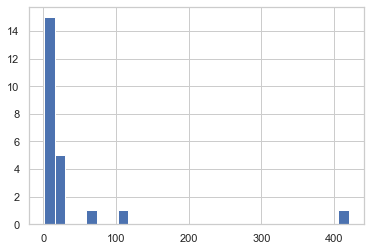

In [142]:
# Number of partial raction paras per document
print(max(half_paras_per_doc))
_,_,_ = plt.hist([v for v in half_paras_per_doc if v > 0],bins = 'auto')

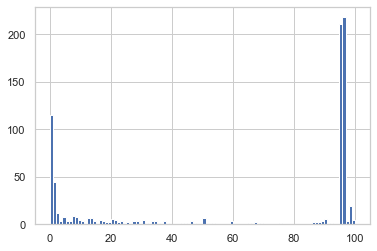

In [156]:
# Percentage of reaction chars in partial reaction para
_,_,_ = plt.hist([n/d * 100 for n, d in zip(reaction_char_count,half_para_char_cnt) ], bins = 100)

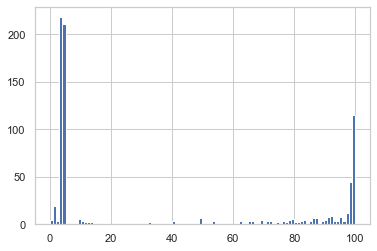

In [157]:
# Percentage of  non - reaction chars in partial reaction para
_,_,_ = plt.hist([n/d * 100 for n, d in zip(non_reaction_char_cnt,half_para_char_cnt)], bins = 100)

1328.0


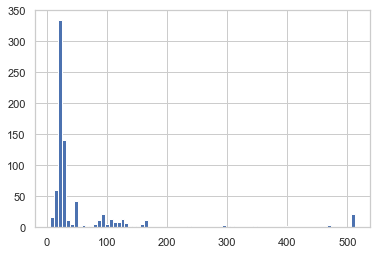

In [152]:
# Distribution of reaction chars in partial reaction para
print(max(reaction_char_count))
_,_,_ = plt.hist([min(r, 512) for r in reaction_char_count], bins = 'auto')

20348.0


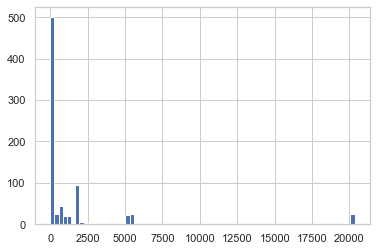

In [154]:
# Distribution of non-reaction chars in partial reaction para
print(max(non_reaction_char_cnt))
_,_,_ = plt.hist([r for r in non_reaction_char_cnt], bins = 'auto')